In [2]:
import os
import sys
import pandas as pd
from tabulate import tabulate
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torchvision.models as models

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Specify the folder containing the images and the file path of the csv file.
current_dir = os.getcwd()
img_dir = "/home/featurize/data/202018010140_CHC6781_Machine_Vision_Coursework/Images"
annotations_file = "/home/featurize/data/202018010140_CHC6781_Machine_Vision_Coursework/glaucoma.csv"
df = pd.read_csv(annotations_file)

def resize_and_pad(img, size):
    # Calculate the aspect ratio and determine the new dimensions.
    aspect = img.width / img.height
    new_width, new_height = (size, int(size / aspect)) if aspect > 1 else (int(size * aspect), size)

    # Resize the image.
    img = TF.resize(img, (new_height, new_width))

    # Calculate the padding on both sides.
    pad_width_l = (size - new_width) // 2
    pad_width_r = size - new_width - pad_width_l
    pad_height_u = (size - new_height) // 2
    pad_height_d = size - new_height - pad_height_u

    # Padding the image.
    img = TF.pad(img, (pad_width_l, pad_height_u, pad_width_r, pad_height_d), fill=0)

    return img


class MyDataset(Dataset):
    def __init__(self, annotations_df, img_dir, transform=None):     
        self.img_labels = annotations_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, -1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Using a custom resize_and_pad function.
transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_and_pad(img, 512)),
    transforms.CenterCrop((360, 360)),
    transforms.ToTensor(),
])

# Creating a dataset instance.
dataset = MyDataset(annotations_df=df, img_dir=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=8)

# Initialization.
mean = torch.zeros(3)
std = torch.zeros(3)
n_samples = 0

# Compute mean.
for images, _ in dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    n_samples += batch_samples

mean /= n_samples

# Compute the standard deviation.
for images, _ in dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    std += ((images - mean.unsqueeze(1))**2).sum([0, 2])

std = torch.sqrt(std / (n_samples*360*360))

# Create a list containing mean and standard deviation.
mean_list = mean.numpy().tolist()
std_list = std.numpy().tolist()

stats = [
    ['Mean', mean_list],
    ['Std', std_list]
]

# Print a table using tabulate.
print(tabulate(stats, headers=['Statistic', 'Value']))

Statistic    Value
-----------  ---------------------------------------------------------------
Mean         [0.5746562480926514, 0.34748515486717224, 0.15272480249404907]
Std          [0.25267958641052246, 0.15881849825382233, 0.09417859464883804]


In [3]:
# Dividing the dataset into 70% for training, 15% for validation, and 15% for testing.
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=0)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=0)

# Defining transformation operations for resizing, cropping, normalization, and other image manipulations.
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: resize_and_pad(img, 512)),
    transforms.CenterCrop((360, 360)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5747, 0.3475, 0.1527], std=[0.2527, 0.1588, 0.0942]),
])
transform_test = transforms.Compose([
    transforms.Lambda(lambda img: resize_and_pad(img, 512)),
    transforms.CenterCrop((360, 360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5747, 0.3475, 0.1527], std=[0.2527, 0.1588, 0.0942]),
])

train_dataset = MyDataset(train_df, img_dir=img_dir, transform=transform_train)
valid_dataset = MyDataset(valid_df, img_dir=img_dir, transform=transform_test)
test_dataset = MyDataset(test_df, img_dir=img_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [4]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


# Spatial Attention Layer
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size=3):
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
    

class InceptionModule(nn.Module):
    def __init__(self, in_channels, f1, f2, f3, f4):
        super(InceptionModule, self).__init__()
        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(True),
        )

        # Branch with 1x1 convolution followed by 3x3 convolution
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, f2, kernel_size=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(True),
            nn.Conv2d(f2, f2, kernel_size=3, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(True),
        )

        # Branch with 1x1 convolution followed by 5x5 convolution
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, f3, kernel_size=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(True),
            nn.Conv2d(f3, f3, kernel_size=5, padding=2),
            nn.BatchNorm2d(f3),
            nn.ReLU(True),
        )

        # Branch with 3x3 max pooling followed by 1x1 convolution
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, f4, kernel_size=1),
            nn.BatchNorm2d(f4),
            nn.ReLU(True),
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        output = torch.cat([branch1, branch2, branch3, branch4], 1)
        return output
    
    

# Defining the ResNet-18 network architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    
class CombineNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CombineNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.inception1 = InceptionModule(64, 16, 16, 16, 16)
        self.inception2 = InceptionModule(64, 32, 32, 32, 32)
        self.inception3 = InceptionModule(128, 64, 64, 64, 64)
        self.inception4 = InceptionModule(256, 128, 128, 128, 128)

        self.sp1 = SpatialAttentionModule()
        self.sp2 = SpatialAttentionModule()
        self.sp3 = SpatialAttentionModule()
        self.sp4 = SpatialAttentionModule()

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)  # [64, 128, 128]

        y1 = self.inception1(x)
        y2 = self.layer1(x)   # [64, 128, 128]
        y2 = self.sp1(y1) * y2

        y1 = self.inception2(y1)
        y1 = self.maxpool(y1)  # [128, 64, 64]
        y2 = self.layer2(y2)   # [128, 64, 64]
        y2 = self.sp2(y1) * y2

        y1 = self.inception3(y1)
        y1 = self.maxpool(y1)  # [256, 32, 32]
        y2 = self.layer3(y2)   # [256, 32, 32]
        y2 = self.sp3(y1) * y2

        y1 = self.inception4(y1)
        y1 = self.maxpool(y1)  # [512, 16, 16]
        y2 = self.layer4(y2)   # [512, 16, 16]
        y2 = self.sp4(y1) * y2

        y2 = self.avgpool(y2)
        y2 = y2.view(y2.size(0), -1)
        y2 = self.fc(y2)
        y2 = self.dropout(y2)
        return y2

# Instantiating the ResNet-18 model
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=1)

In [5]:
class Loss(nn.Module):
    def __init__(self, pos_weight, gamma=1.5):
        super(Loss, self).__init__()
        self.pos_weight = pos_weight
        self.gamma = gamma

    def forward(self, logits, targets):
        epsilon = 1e-12
        predictions = torch.sigmoid(logits)
        predictions = torch.clamp(predictions, epsilon, 1. - epsilon)
        loss = -self.pos_weight * targets * (1 - predictions) ** self.gamma * torch.log(predictions) - \
            (1 - self.pos_weight) * (1 - targets)  * (predictions ** self.gamma) * torch.log(1 - predictions)
        return loss.mean()

In [6]:
#model = ResNet18()
#model_path = '/home/featurize/data/202018010140_CHC6781_Machine_Vision_Coursework/best_model_weights.pth'
#model.load_state_dict(torch.load(model_path), strict=False)
model = CombineNet(BasicBlock, [2, 2, 2, 2], num_classes=1)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = Loss(pos_weight=0.75)
#model = models.resnet50(weights=None)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 1)

num_epochs = 200
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
total_steps = num_epochs * len(train_loader)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=10 * lr, total_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CombineNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, k

In [7]:
def EpochRunner(model, train_loader, optimizer, lr_scheduler, loss_fn, device):
    model.train()
    total_loss = 0
    # Creating progress bars using tqdm library
    loop = tqdm(train_loader,  total=len(train_loader), file=sys.stdout)
    for data, target in loop:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output.view(-1), target.float())
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()
        # Updating the progress bar
        loop.set_postfix(loss=loss.item(), lr=optimizer.state_dict()['param_groups'][0]['lr'])
    return total_loss / len(train_loader)

def validate(model, valid_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output.view(-1), target.float())
            total_loss += loss.item()

            # Calculating accuracy
            predicted = torch.sigmoid(output).ge(0.5).view(-1)  # Using 0.5 as a threshold for classification
            correct += (predicted == target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(valid_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [8]:
best_valid_loss = float('inf')
training_results = []

for epoch in range(num_epochs):
    train_loss = EpochRunner(model, train_loader, optimizer, lr_scheduler, loss_fn, device)
    if epoch % 5 == 0:
        valid_loss, valid_accuracy = validate(model, valid_loader, loss_fn, device)
        training_results.append((epoch + 1, train_loss, valid_loss, valid_accuracy))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')
        # Save the model with the minimum validation loss.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model_weights_1.pth')
            print('Best model saved')

with open('training_log.txt', 'w') as f:
    for epoch, train_loss, valid_loss, valid_accuracy in training_results:
        f.write(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, '
                f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}\n')

torch.save(model.state_dict(), 'last_model_weights.pth')
print('Last epoch model saved')

100%|██████████| 15/15 [00:08<00:00,  1.68it/s, loss=0.0956, lr=4.07e-5]
Epoch: 1, Training Loss: 0.1013, Validation Loss: 0.1126, Validation Accuracy: 0.6804
Best model saved
100%|██████████| 15/15 [00:04<00:00,  3.24it/s, loss=0.0916, lr=6.35e-5]
Epoch: 6, Training Loss: 0.0953, Validation Loss: 0.1211, Validation Accuracy: 0.6598
100%|██████████| 15/15 [00:04<00:00,  3.28it/s, loss=0.102, lr=0.000118] 
Epoch: 11, Training Loss: 0.0868, Validation Loss: 0.1006, Validation Accuracy: 0.5258
Best model saved
100%|██████████| 15/15 [00:04<00:00,  3.42it/s, loss=0.0935, lr=0.000199]
Epoch: 16, Training Loss: 0.0933, Validation Loss: 0.0949, Validation Accuracy: 0.3918
Best model saved
100%|██████████| 15/15 [00:04<00:00,  3.38it/s, loss=0.0815, lr=0.000303]
Epoch: 21, Training Loss: 0.0877, Validation Loss: 0.0899, Validation Accuracy: 0.5464
Best model saved
100%|██████████| 15/15 [00:04<00:00,  3.47it/s, loss=0.111, lr=0.000421] 
Epoch: 26, Training Loss: 0.0893, Validation Loss: 0.0908

In [9]:
ckpt_path = '/home/featurize/data/202018010140_CHC6781_Machine_Vision_Coursework/best_model_weights_1.pth'
model.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
model.eval()  # Set the model to evaluation mode.

# Initialize variables for metric computation.
correct = 0
total = 0
all_targets = []
all_predictions = []
all_logits = []

# Not requiring gradient computation.
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        logits = torch.sigmoid(outputs).view(-1)
        predicted = torch.sigmoid(outputs).ge(0.5).view(-1)  # Using 0.5 as the threshold for classification.
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collecting all the ground truth labels and predicted results.
        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_logits.extend(logits.cpu().numpy())

# Calculating accuracy.
accuracy = correct / total

all_targets_np = np.array(all_targets)
all_predictions_np = np.array(all_predictions)
all_logits_np = np.array(all_logits)

# The elements of the confusion matrix.
TP = np.sum((all_predictions_np == 1) & (all_targets_np == 1))
TN = np.sum((all_predictions_np == 0) & (all_targets_np == 0))
FP = np.sum((all_predictions_np == 1) & (all_targets_np == 0))
FN = np.sum((all_predictions_np == 0) & (all_targets_np == 1))

# Calculating evaluation metrics.
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Metrics data
metrics = [
    ['Accuracy', accuracy],
    ['Precision', precision],
    ['Recall', recall],
    ['Specificity', specificity],
    ['F1 Score', f1_score]
]

# Print a table using tabulate
print(tabulate(metrics, headers=['Metric', 'Value'], floatfmt=".4f"))

Metric         Value
-----------  -------
Accuracy      0.6020
Precision     0.3043
Recall        0.6667
Specificity   0.5844
F1 Score      0.4179


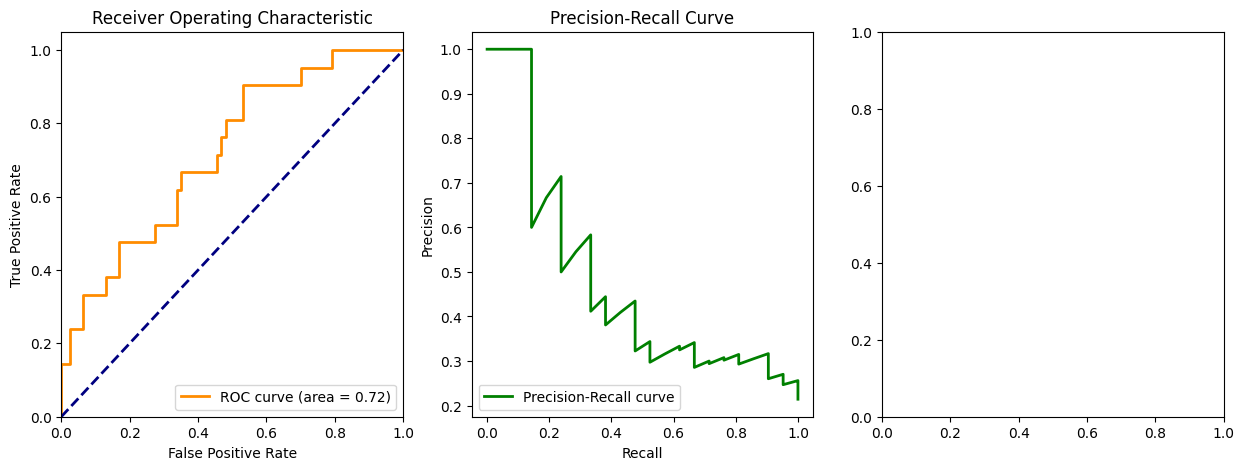

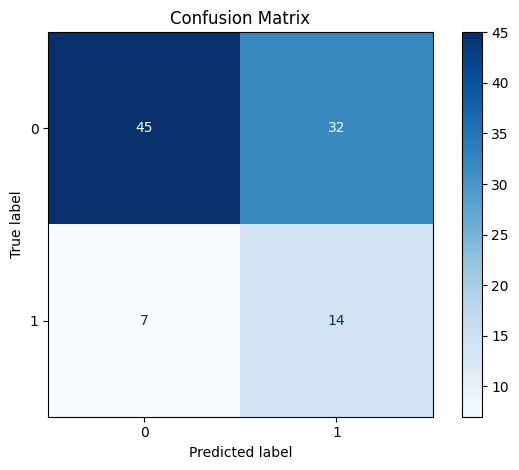

In [10]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Calculate parameters for the ROC curve.
fpr, tpr, thresholds = roc_curve(all_targets_np, all_logits_np)
roc_auc = auc(fpr, tpr)

# Calculate parameters for precision-recall curve.
precision, recall, _ = precision_recall_curve(all_targets_np, all_logits_np)

# Calculate the confusion matrix
cm = confusion_matrix(all_targets_np, all_predictions_np)

# Plotting the ROC-AUC curve.
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plotting the precision-recall curve.
plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Displaying the confusion matrix.
plt.subplot(1, 3, 3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


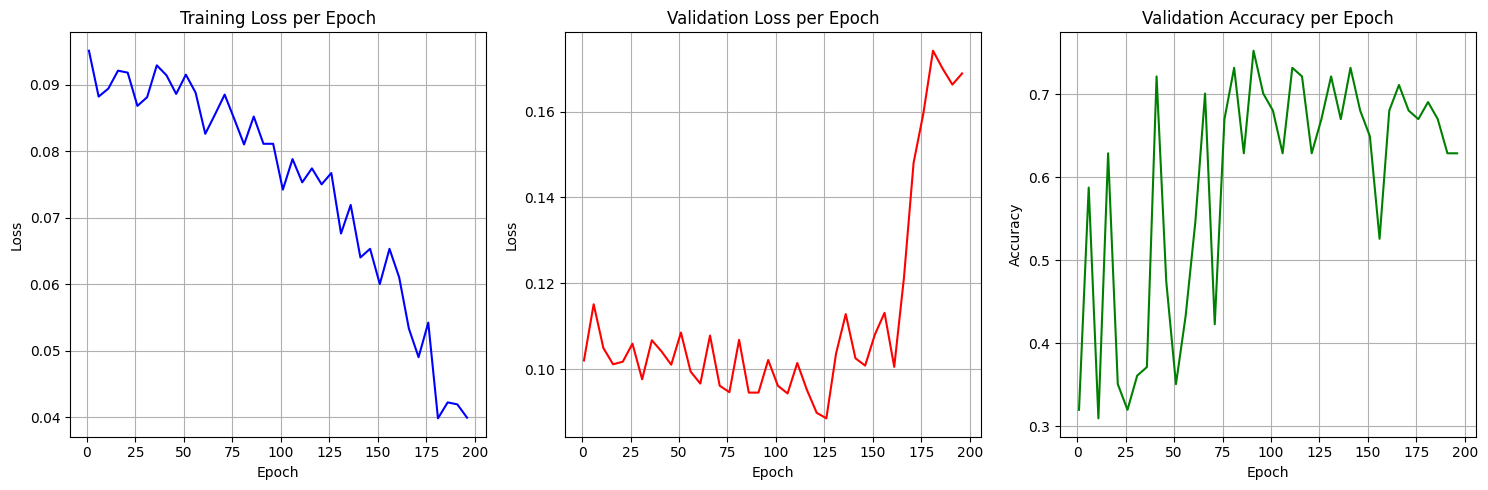

In [10]:
with open('/home/featurize/data/202018010140_CHC6781_Machine_Vision_Coursework/training_log.txt', 'r') as file:
    training_log = file.readlines()

import re

# Parsing the training log data
epochs = []
training_losses = []
validation_losses = []
validation_accuracies = []

# Regular expression to extract data from each line
pattern = r'Epoch: (\d+), Training Loss: ([\d\.]+), Validation Loss: ([\d\.]+), Validation Accuracy: ([\d\.]+)'

for line in training_log:
    match = re.match(pattern, line)
    if match:
        epoch, train_loss, val_loss, val_acc = match.groups()
        epochs.append(int(epoch))
        training_losses.append(float(train_loss))
        validation_losses.append(float(val_loss))
        validation_accuracies.append(float(val_acc))

# Plotting the data
plt.figure(figsize=(15, 5))

# Training Loss Plot
plt.subplot(1, 3, 1)
plt.plot(epochs, training_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)

# Validation Loss Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, validation_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.grid(True)

# Validation Accuracy Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, validation_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()